Chargement du dataset...
Dataset chargé avec succès.
Conversion des valeurs cibles en sentiments effectuée.
Nettoyage du texte...
Nettoyage du texte effectué.
Tokenisation des textes...
Tokenisation effectuée.
Affichage d'un échantillon des données nettoyées et tokenisées:
                                        cleaned_text  \
0     awww thats a bummer  you shoulda got david ...   
1  is upset that he cant update his facebook by t...   
2   i dived many times for the ball managed to sa...   
3    my whole body feels itchy and like its on fire    
4   no its not behaving at all im mad why am i he...   
5                                not the whole crew    
6                                        need a hug    
7   hey  long time no see yes rains a bit only a ...   
8                           nope they didnt have it    
9                                     que me muera     

                                              tokens sentiment  
0  [awww, thats, a, bummer, you, shoulda, go

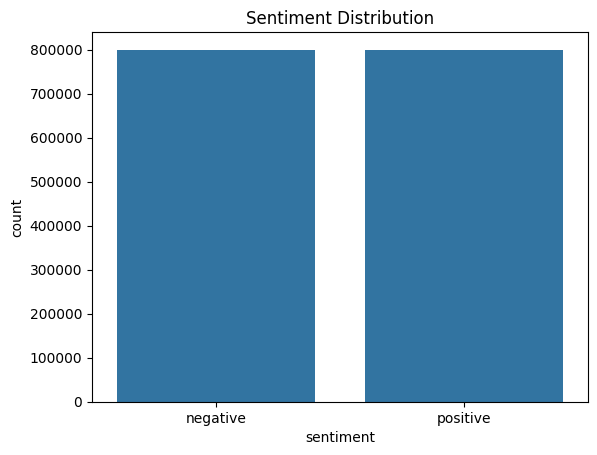

Génération du nuage de mots...


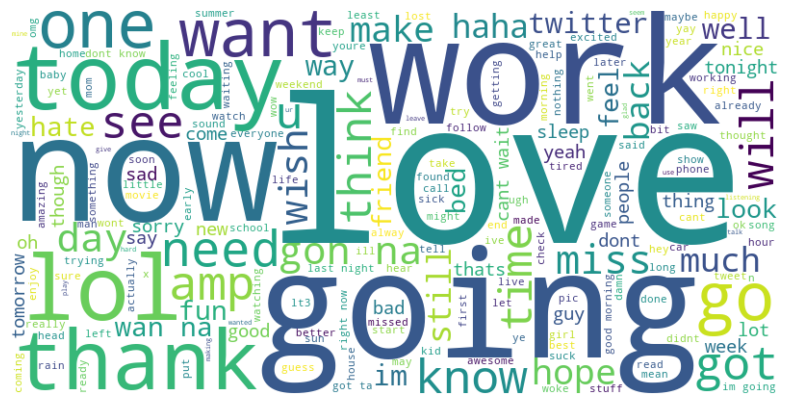

Affichage de la distribution des longueurs des tweets...


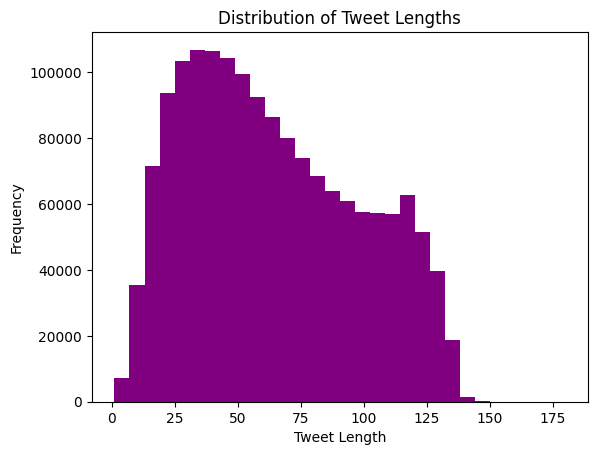

Application de CountVectorizer (Bag of Words)...
Vectorisation avec CountVectorizer effectuée.
Application de TfidfVectorizer...
Vectorisation avec TfidfVectorizer effectuée.
Chargement des embeddings GloVe...
Embeddings GloVe chargés.
Application des embeddings GloVe...
Embeddings GloVe appliqués.
Analyse de sentiment avec VADER...
Analyse de sentiment effectuée.
Affichage des résultats finaux:
                                        cleaned_text sentiment  \
0     awww thats a bummer  you shoulda got david ...  negative   
1  is upset that he cant update his facebook by t...  negative   
2   i dived many times for the ball managed to sa...  negative   
3    my whole body feels itchy and like its on fire   negative   
4   no its not behaving at all im mad why am i he...  negative   
5                                not the whole crew   negative   
6                                        need a hug   negative   
7   hey  long time no see yes rains a bit only a ...  negative   
8      

In [4]:
import pandas as pd
import re
from nltk.tokenize import word_tokenize
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Télécharger les ressources nécessaires
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('vader_lexicon')

# Charger le dataset
print("Chargement du dataset...")
data = pd.read_csv("E:/sentement140/training.1600000.processed.noemoticon.csv", encoding='ISO-8859-1', header=None)
data.columns = ["target", "id", "date", "flag", "user", "text"]
print("Dataset chargé avec succès.")

# Sélectionner les colonnes pertinentes
data = data[["target", "text"]]

# Convertir les valeurs cibles en sentiments
data['sentiment'] = data['target'].replace({0: "negative", 4: "positive", 2: "neutral"})
print("Conversion des valeurs cibles en sentiments effectuée.")

# Fonction pour nettoyer le texte
def clean_text(text):
    text = re.sub(r'http\S+', '', text)     # Supprimer les URLs
    text = re.sub(r'@\w+', '', text)        # Supprimer les mentions
    text = re.sub(r'#\w+', '', text)        # Supprimer les hashtags
    text = re.sub(r'[^\w\s]', '', text)     # Supprimer les caractères spéciaux
    text = text.lower()                     # Mettre tout en minuscules
    return text

# Appliquer le nettoyage
print("Nettoyage du texte...")
data['cleaned_text'] = data['text'].apply(clean_text)
print("Nettoyage du texte effectué.")

# Appliquer la tokenisation sur le texte nettoyé
print("Tokenisation des textes...")
data['tokens'] = data['cleaned_text'].apply(word_tokenize)
print("Tokenisation effectuée.")

# Afficher un échantillon des données nettoyées et tokenisées
print("Affichage d'un échantillon des données nettoyées et tokenisées:")
print(data[['cleaned_text', 'tokens', 'sentiment']].head(10))

# Visualiser la distribution des sentiments
print("Affichage de la distribution des sentiments...")
sns.countplot(x='sentiment', data=data)
plt.title('Sentiment Distribution')
plt.show()

# Générer le nuage de mots
print("Génération du nuage de mots...")
all_words = ' '.join([' '.join(tokens) for tokens in data['tokens']])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Analyser la distribution des longueurs de tweet
print("Affichage de la distribution des longueurs des tweets...")
data['tweet_length'] = data['cleaned_text'].apply(len)

plt.hist(data['tweet_length'], bins=30, color='purple')
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

# Vectorisation avec CountVectorizer
print("Application de CountVectorizer (Bag of Words)...")
vectorizer = CountVectorizer(max_features=5000)
X_bow = vectorizer.fit_transform(data['cleaned_text'])
print("Vectorisation avec CountVectorizer effectuée.")

# Vectorisation avec TfidfVectorizer
print("Application de TfidfVectorizer...")
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(data['cleaned_text'])
print("Vectorisation avec TfidfVectorizer effectuée.")

# Chargement des embeddings GloVe
print("Chargement des embeddings GloVe...")
embeddings_index = {}
with open('E:/sentement140/glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print("Embeddings GloVe chargés.")

# Fonction pour obtenir le vecteur d'embedding d'un tweet
def get_embedding_vector(tokens):
    embedding_matrix = np.zeros((len(tokens), 100))  # 100 est la taille du vecteur GloVe
    valid_tokens = 0  # Compteur pour les tokens valides trouvés dans les embeddings GloVe
    
    for i, word in enumerate(tokens):
        embedding_vector = embeddings_index.get(word, None)
        if embedding_vector is not None:  # Si le mot est trouvé dans l'index GloVe
            embedding_matrix[i] = embedding_vector
            valid_tokens += 1
    
    if valid_tokens > 0:
        return np.mean(embedding_matrix[:valid_tokens], axis=0)
    else:
        return np.zeros(100)  # Si aucun mot valide n'a été trouvé, retourner un vecteur nul

# Appliquer les embeddings GloVe aux tweets
print("Application des embeddings GloVe...")
data['tweet_embedding'] = data['tokens'].apply(get_embedding_vector)
print("Embeddings GloVe appliqués.")

# Analyse de sentiment avec VADER
print("Analyse de sentiment avec VADER...")
sid = SentimentIntensityAnalyzer()
data['sentiment_score'] = data['cleaned_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
print("Analyse de sentiment effectuée.")

# Afficher les résultats finaux
print("Affichage des résultats finaux:")
print(data[['cleaned_text', 'sentiment', 'sentiment_score']].head(10))
